# Models 

In [1]:
import os
import sys
import yaml
import pandas as pd
import pyarrow
import pickle

In [2]:
# Import yaml file in order to access global variables and paths
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
# useful python modules for the project
import graph_properties
from src.utils import load_pickle
from src.modeling import get_metrics, plot_matriz
from src.utils import render_mpl_table

In [3]:
# Loading config file
config_name = "config.yaml"
with open(os.path.join(parent_dir, config_name), encoding="utf-8") as conf:
        config_f = yaml.safe_load(conf)

<strong>Note:</strong><br>
I have modularized the entire process of cleaning, training, and testing the model. As a result, the codebase can be found in the 'src' folder. However, I will execute the code step by step in the Jupyter cells and provide an explanation of the process.

## Data cleaning process

For consistency across all the tested models, I have already split the train and test dataframes into two separate files. You can find the process detailed in the 'src/training.py' script.

In [4]:
#This step produces a clean parquet dataframe containing the variables that will be used for the modeling process
%run ../src/cleaning.py

Only "BALANCE_DUE" and "CREDIT_LIMIT" have null values, which will be processed differently according to the employed algorithm.

## Logistic regression

Due to the binary nature of this problem, I will begin by using logistic regression as an initial benchmark. In the 'logistic_regression.py' module, I have a detailed pipeline for training. Within this section, I perform grid search with cross-validation to identify the best logistic regression model based on a predefined parameter grid.

In [5]:
%run ../src/logistic_regression.py

In [6]:
filename_preprocessor = config_f["models"]["logistic_regression"]["preprocessor"]
loaded_preprocessor = load_pickle(filename_preprocessor)

### Logistic regression: Preprocessing

In [7]:
loaded_preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['BALANCE_DUE', 'CREDIT_LIMIT',
                                  'FINANCED_AMOUNT',
                                  'account_to_application_days', 'n_sf_apps',
                                  'n_bnpl_apps', 'n_inquiries_l3m']),
                                ('nom',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['LOAN_TERM_MONTHLY', 'APPLICATION_MONTH',
                                  'APPLICATION_YEAR'])])

#### Preprocessing steps for logistic regression
- In the preprocessing steps for the logistic regression algorithm, the variables "BALANCE_DUE" and "CREDIT_LIMIT" will undergo a simple imputation treatment, where the missing values will be assigned the mean of the available values.
- All the numerical variables have undergone standard scaling as part of the preprocessing.
- The categorical loan variables (LOAN_TERM_MONTHLY, APPLICATION_MONTH, and APPLICATION_YEAR) were one-hot encoded.

### Logistic regression: Model training and testing

In [8]:
filename_model = config_f["models"]["logistic_regression"]["model"]
loaded_model = load_pickle(filename_model)

In [9]:
loaded_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BALANCE_DUE',
                                                   'CREDIT_LIMIT',
                                                   'FINANCED_AMOUNT',
                                                   'account_to_application_days',
                                                   'n_sf_apps', 'n_bnpl_apps',
                                                   'n_inquiries_l3m']),
                                                 ('nom',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['LOAN_TERM_MONTHLY',
                                                   'APPLICATION_MONTH',
                                                   'APPLICATION_YEAR'])])),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression',
                 LogisticRegression(C=0.4, max_iter=2500, random_state=42,
                                    solver='liblinear'))])

The complete preprocessing and training pipeline can be found in 'src/logistic_regression.py.' Here, I will simply load the prediction results for the train and test datasets. I chose to employ the SMOTE (Synthetic Minority Over-sampling Technique) to address class imbalance in the dataset. Previous attempts without balancing the minority class (representing clients who defaulted) produced unsatisfactory results. In fact, the logistic regression estimator predicted the mean value for all observations. By implementing the balancing technique, I managed to achieve improved results. It's important to note that these results are considered an initial benchmark, and I anticipate that other algorithms will surpass them.

### Logistic regression: Evaluation metrics

I have observed poor performance with the trained model. In particular, due to subtle discrepancies between the training and test data sets, it appears that the model may suffer from high bias. Therefore, it is necessary to explore alternative models that may better capture the true distribution of the data. Although logistic regression yielded only a slightly better result than a random classifier, I will now investigate other approaches

In [10]:
metrics, cm = get_metrics('logistic_regression')

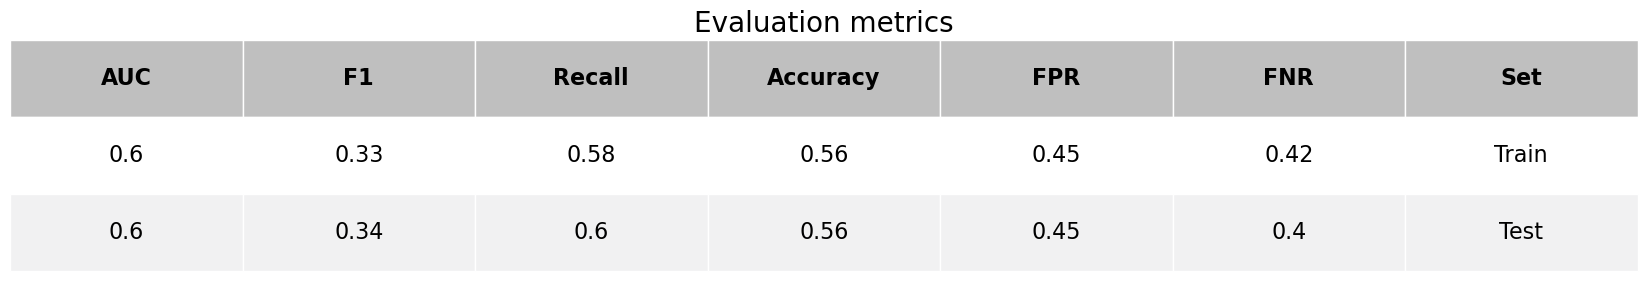

In [11]:
render_mpl_table(metrics, title="Evaluation metrics")

In [12]:
cm_test = cm['Test']
cm_train = cm['Train']
labels = loaded_model.classes_

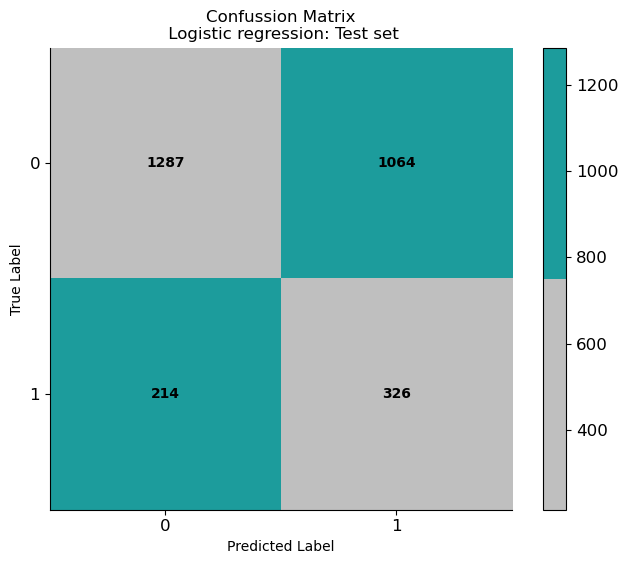

In [13]:
plot_matriz(cm_test, labels, "Confussion Matrix\n Logistic regression: Test set")

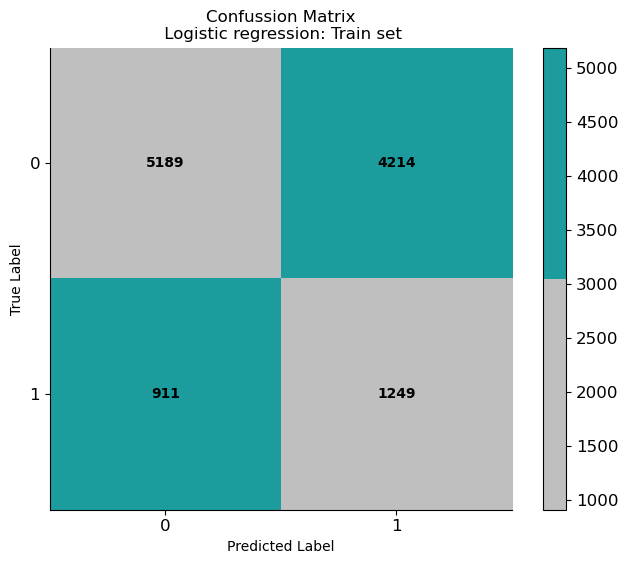

In [14]:
plot_matriz(cm_train, labels, "Confussion Matrix\n Logistic regression: Train set")


## Random Forest

Training pipeline is in the random_forest.py script

In [15]:
%run ../src/random_forest.py

### Random forest classifier: Preprocessing

In [16]:
filename_preprocessor = config_f["models"]["random_forest"]["preprocessor"]
loaded_preprocessor = load_pickle(filename_preprocessor)

In [17]:
loaded_preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['BALANCE_DUE', 'CREDIT_LIMIT',
                                  'FINANCED_AMOUNT',
                                  'account_to_application_days', 'n_sf_apps',
                                  'n_bnpl_apps', 'n_inquiries_l3m']),
                                ('nom',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['LOAN_TERM_MONTHLY', 'APPLICATION_MONTH',
                                  'APPLICATION_YEAR'])])

The preprocessing steps applied to the Random Forest classifier are identical to those I applied to the logistic regression classifier.

### Random forest classifier: 
Model training and testing

In [18]:
filename_model = config_f["models"]["random_forest"]["model"]
loaded_model = load_pickle(filename_model)

In [19]:
loaded_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BALANCE_DUE',
                                                   'CREDIT_LIMIT',
                                                   'FINANCED_AMOUNT',
                                                   'account_to_application_days',
                                                   'n_sf_apps', 'n_bnpl_apps',
                                                   'n_inquiries_l3m']),
                                                 ('nom',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['LOAN_TERM_MONTHLY',
                                                   'APPLICATION_MONTH',
                                                   'APPLICATION_YEAR'])])),
                ('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        n_estimators=20, random_state=42))])

### Random Forest classifier: Evaluation metrics

Despite the Random Forest classifier showing better performance on the training set than the logistic regression classifier, its performance on the test set is poor. This suggests that we are experiencing overfitting in the model.

In [20]:
metrics, cm = get_metrics('random_forest')

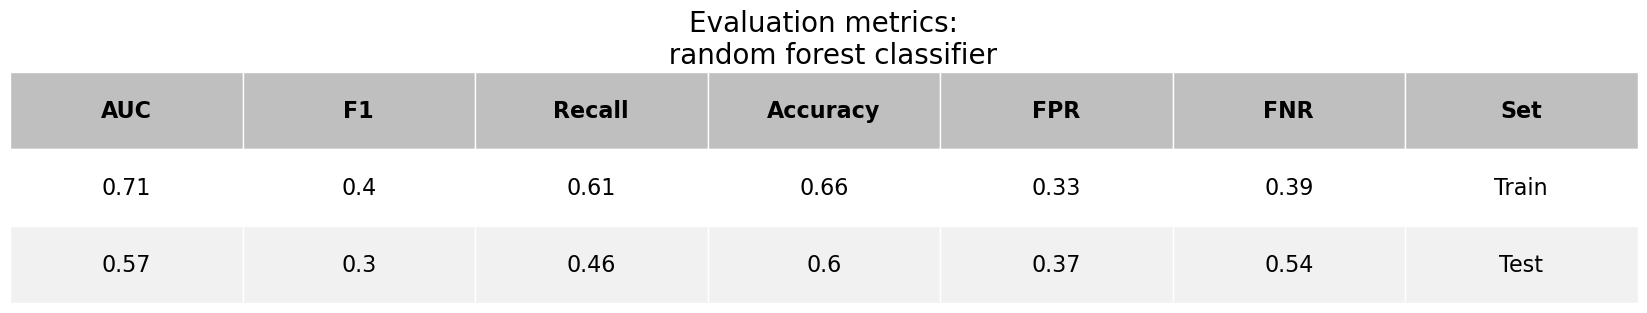

In [21]:
render_mpl_table(metrics, title="Evaluation metrics:\n  random forest classifier")

In [22]:
cm_test = cm['Test']
cm_train = cm['Train']
labels = loaded_model.classes_

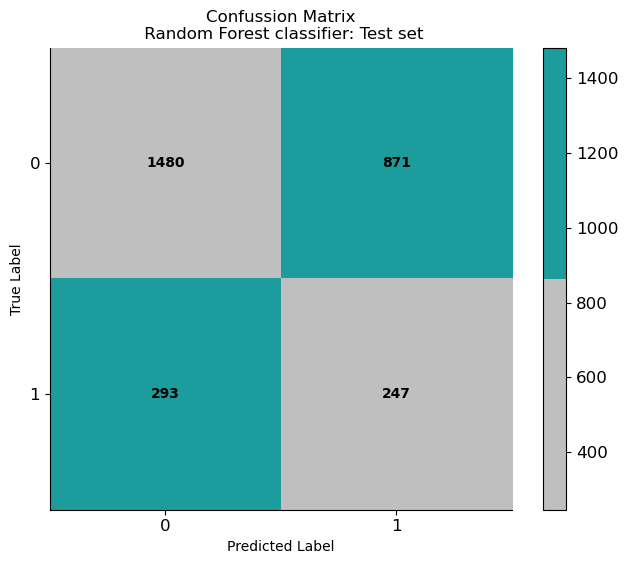

In [23]:
plot_matriz(cm_test, labels, "Confussion Matrix\n Random Forest classifier: Test set")

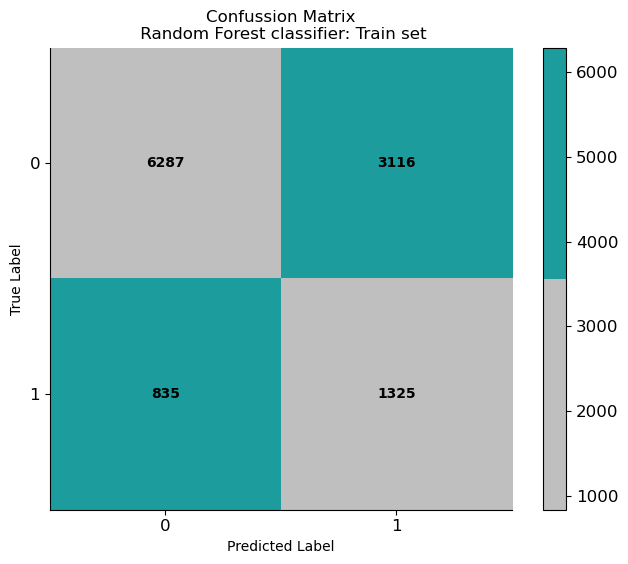

In [24]:
plot_matriz(cm_train, labels, "Confussion Matrix\n Random Forest classifier: Train set")

## Xgboost classifier

In [25]:
%run ../src/xgboost_classifier.py

### Random forest classifier: Preprocessing

In [26]:
filename_preprocessor = config_f["models"]["xgboost"]["preprocessor"]
loaded_preprocessor = load_pickle(filename_preprocessor)

In [27]:
loaded_preprocessor


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['BALANCE_DUE', 'CREDIT_LIMIT',
                                  'FINANCED_AMOUNT',
                                  'account_to_application_days', 'n_sf_apps',
                                  'n_bnpl_apps', 'n_inquiries_l3m']),
                                ('nom',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['LOAN_TERM_MONTHLY', 'APPLICATION_MONTH',
                                  'APPLICATION_YEAR'])])

### Xgboost classifier: Evaluation metrics

In [28]:
filename_model = config_f["models"]["xgboost"]["model"]
loaded_model = load_pickle(filename_model)

In [29]:
loaded_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['BALANCE_DUE',
                                                   'CREDIT_LIMIT',
                                                   'FINANCED_AMOUNT',
                                                   'account_to_application_days',
                                                   'n_sf_apps', 'n_bnpl_apps',
                                                   'n_inquiries_l3m']),
                                                 ('nom',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=35,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [30]:
metrics, cm = get_metrics('xgboost')

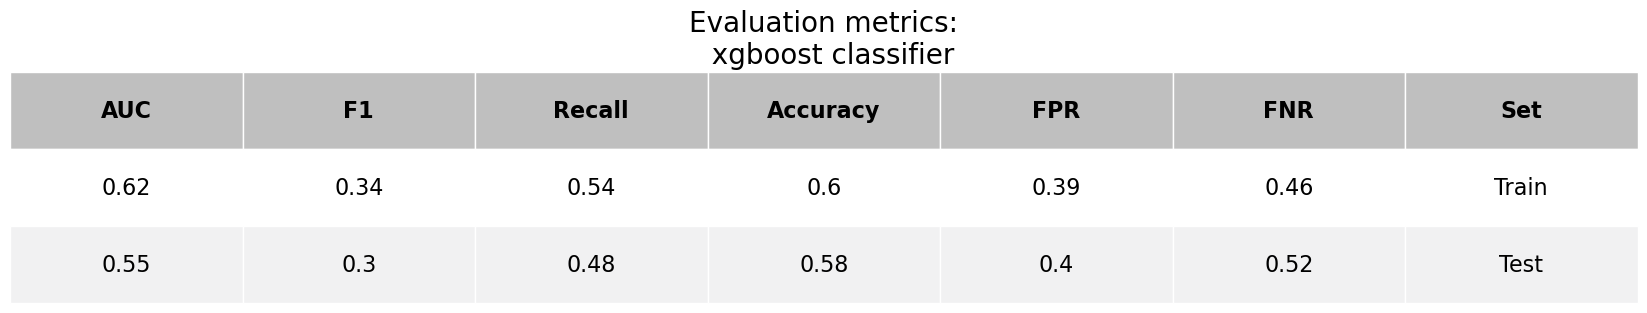

In [31]:
render_mpl_table(metrics, title="Evaluation metrics:\n  xgboost classifier")

In [32]:
cm_test = cm['Test']
cm_train = cm['Train']
labels = loaded_model.classes_

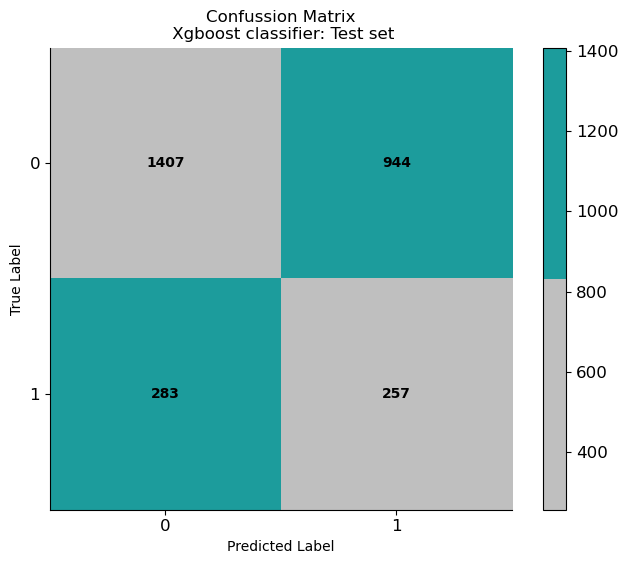

In [33]:
plot_matriz(cm_test, labels, "Confussion Matrix\n Xgboost classifier: Test set")

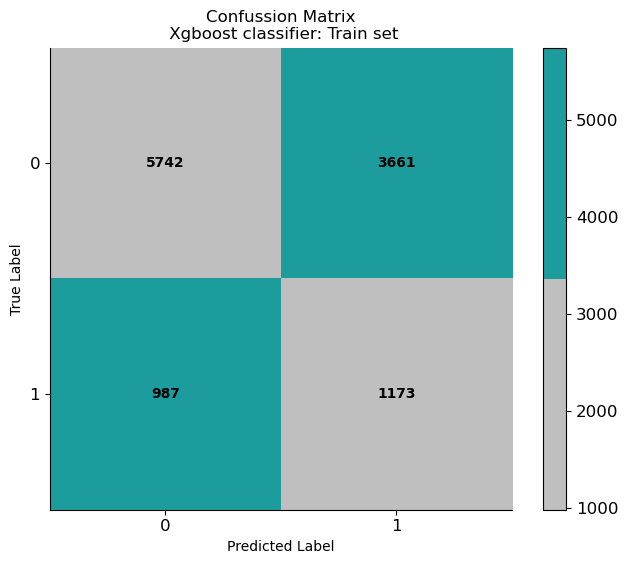

In [34]:
plot_matriz(cm_train, labels, "Confussion Matrix\n Xgboost classifier: Train set")